In [46]:
# v5: change hadcrut to C&W
# v9: add constant offset method for adjusting cmip6 temps

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import scipy.stats as stats

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [47]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=10

#exp='ssp370'
exp='ssp245'
#exp='ssp126'


temp_correction_method = 'scale' #options are 'scale' or 'offset'


## observations
CW_file = 'int_outputs/temperature_CW/CW_tas.csv'

Obs_df = preprocess_obs(pd.read_csv(CW_file), window=window)
obs_set = 'Cowtan & Way'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available
### define one tas_df used for both plots, this contains all ensemble members

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=True)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model', 'Ensemble_member'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(len(models))


43


In [48]:

### define a first ensemble member version of tas_df

# this (somewhat hacky) code tries ensemble members in the order below ...
# to see what label the first member for each model has
member_labels_to_try = ['r1i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r1i1p1f2', 'r1i2p1f1', 'r1i1p1f3', 'r4i1p1f1']

tas_df_1st_mem = tas_df[tas_df['Ensemble_member']==member_labels_to_try[0]]
for model in models:
    df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)
models_1st_mem = tas_df_1st_mem['Model'].unique()
remaining_models = set(models).difference(models_1st_mem)
print(len(remaining_models))

i=1
for i in range(1,len(member_labels_to_try)):    
    df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
    tas_df_1st_mem = pd.concat([tas_df_1st_mem, df_to_append])

    for model in models:
        df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
        if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
            tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

    models_1st_mem = tas_df_1st_mem['Model'].unique()
    remaining_models = set(models).difference(models_1st_mem)

    print(len(remaining_models))
    i=i+1
#print(remaining_models)
print(len(tas_df_1st_mem['Model'].unique()))
print(len(tas_df_1st_mem[tas_df_1st_mem['year']==1850]))

10
10
9


/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


2
2
1


/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_546/4258750893.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


0
43
43


In [49]:
### drop model E3SM-1-1 as the run only goes to 2024
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if df_test.year.max() < 2099:
        print(model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

### drop ensemble members which only have a historical run from tas_df
print(len(tas_df))
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not exp in df_test['Experiment'].unique():
            #print(model+ens+'  no ssp245')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

### check whether any ensemble members are incomplete
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if df_test.year.max() < 2099:
            #print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

## update models to represent the final list of 42
models = tas_df['Model'].unique()
print(len(models))

E3SM-1-1
65067


/tmp/ipykernel_546/2274232232.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_546/2274232232.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


44818


/tmp/ipykernel_546/2274232232.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_546/2274232232.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


42634
42


In [50]:
global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])


for temp_thresh in [1.5, 2]:

    Model = []
    No_arctic = []
    World = []
    
    M_df = pd.DataFrame(columns=tas_df_1st_mem.columns)

    blues = []
    reds = []
    years = []

    for m in models:
        #print(m)
        m_df = tas_df_1st_mem[tas_df_1st_mem['Model']==m] #use the 1st ens mem only df
        
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        offset_w = (m_df[m_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
        offset_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]
        
        if temp_correction_method == 'scale':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom']/ratio_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom'] - offset_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom'] - offset_na)
            
        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=0)

        #also calc crossings
        # if no crossing by 2100 (which is the case for Fgoals-g3 under ssp245) extrapolate using linregress for last 20 years
        
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + ' doesnt cross {} without arctic'.format(temp_thresh))
                m_df_regress = m_df[m_df['year'] > 2080].dropna()
                regression = stats.linregress(m_df_regress['year'], m_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print()

observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278

FGOALS-g3 doesnt cross 2 without arctic
extrapolated crossing year: 2100.1991268170823
observation year: 2018
Cowtan & Way temp in obs_year:1.1396610170295498
Cowtan & Way temp without AA in obs_year:1.057631963059219
AA contrib:0.08202905397033078
AA contrib (%)0.07197671302659278



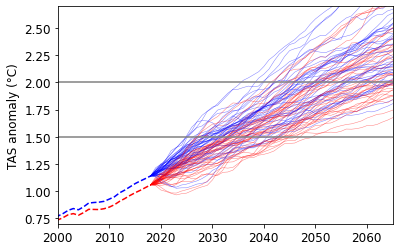

In [51]:
plt.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', label='Observations')
plt.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', label='Observations without AA')


for i in range(len(blues)):
    plt.plot(years[i], blues[i],
             c='b', alpha=0.5, linewidth=0.5, label='CMIP6')
    plt.plot(years[i], reds[i], 
             c='r', alpha=0.5, linewidth=0.5, label='CMIP6 without AA')


plt.xlim(2000,2065)
plt.ylim(0.7, 2.7)
plt.axhline(2, color='gray')
plt.axhline(1.5, color='gray')
plt.ylabel('TAS anomaly (°C)')
plt.savefig('Figures/tas_projections.png', dpi=300)

plt.show()


In [52]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
#out_dfs[temp_thresh]

mean gap for crossing 2C: 7.92 +- 0.8 years


In [53]:
#plt.plot(M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['year'], 
#         M_df[M_df['Model'] == 'FGOALS-g3'].dropna()['adjusted_no_arctic_tas_anom'])
#plt.xlim(2050, 2100)
#plt.ylim(1.5, 2)
#out_dfs

In [54]:
### now repeat calc with multiple ensemble members

# take 1.5C as threshold for this plot if using sp126
if exp == 'ssp126':
    temp_thresh = 1.5
    

Model = []
Ensemble_member = []
No_arctic = []
World = []
for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']==exp]['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
            offset_w = (me_df[me_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
            offset_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]        
        except:
            print('error on: ' + m + e)
 
        if temp_correction_method == 'scale':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom'] - offset_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom'] - offset_na) 
            
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + e + ' doesnt cross {} without arctic'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        if np.isnan(world_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126 
                print(m + e + ' doesnt cross {}'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_world_tas_anom'])
                world_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year (world): {}'.format(str(no_arctic_crossing_year)))
            
        
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

FGOALS-g3r1i1p1f1 doesnt cross 2 without arctic
extrapolated crossing year: 2100.1991268170823


In [55]:
len(out_df_ME.Model.unique())

42

In [56]:
if exp == 'ssp126':
    out_df_ME.dropna(inplace=True)
    

models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

7.751238095238131


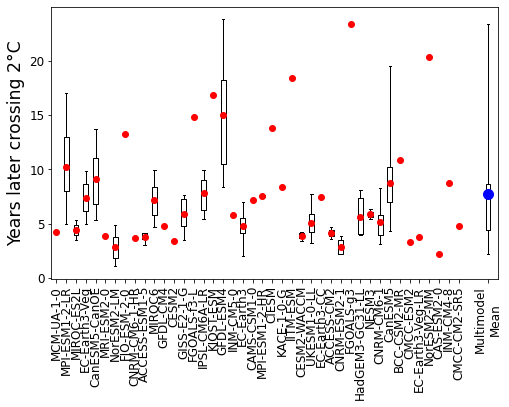

In [57]:
## plot

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)
ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)
ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')


plt.show()

In [58]:
ordered_models = pd.DataFrame({'Model': models,
                               'Ensemble_members_count': None}).set_index('Model')
for model in ordered_models.index:
    count = len(out_df_ME[out_df_ME['Model']==model]['Ensemble_member'].unique())
    ordered_models['Ensemble_members_count'][model] = count

single_mem_models = ordered_models[ordered_models['Ensemble_members_count']==1]
multi_mem_models = ordered_models[ordered_models['Ensemble_members_count'] != 1]

#sort alphabetically for each category
single_mem_models.sort_index(inplace=True)
single_mem_models = single_mem_models[::-1]
multi_mem_models.sort_index(inplace=True)
multi_mem_models = multi_mem_models[::-1]
#recombine
ordered_models = pd.concat([multi_mem_models, single_mem_models])

#print(ordered_models)

In [94]:
print((out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']).median())
print((out_df['No_arctic_crossing_year'].median() - out_df['World_crossing_year'].median()))
    

5.736500000000092
8.549000000000433


In [95]:
print((out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']).mean())
print((out_df['No_arctic_crossing_year'].mean() - out_df['World_crossing_year'].mean()))
  

7.916214285714329
7.916214285715341


Temp Thresh: 1.5
2036.7895714285714 0.8700239548031469 2031.9704761904763 0.7895079483506293
gap:  4.8190952380950876 +- 0.3919114610147407
Temp Thresh: 2
2059.6362857142863 1.9383343036157166 2051.720071428571 1.4091761649527428
gap:  7.916214285715341 +- 0.8015748302685147


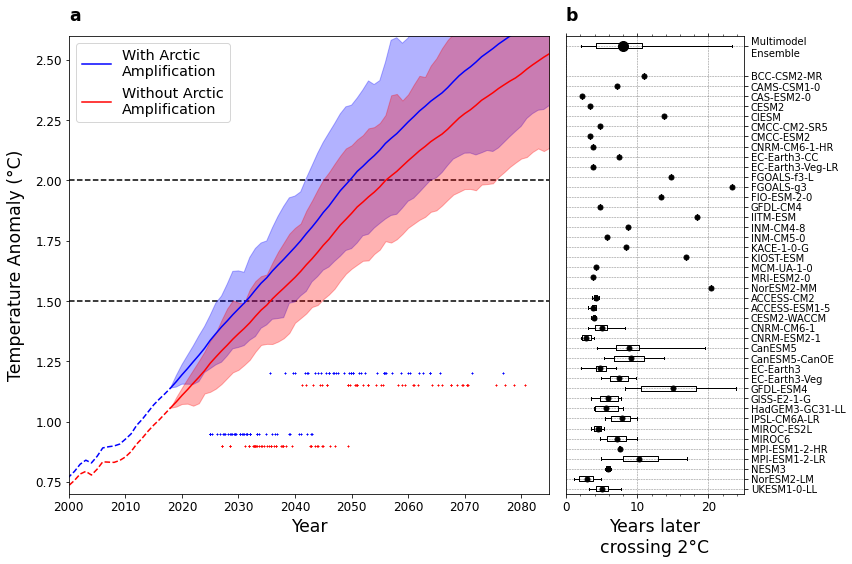

In [144]:
## combine both plots
add_ind_crossing_scatters=True
 
#models = ensemble_members['model']

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in ordered_models.index]
means = np.array([list(v)[0] for v in vectors])
multi_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in multi_mem_models.index]
single_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in single_mem_models.index]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [2.7, 1]})
plt.rcParams['font.size'] = '12'

#for i in range(len(blues)):
#    ax1.plot(years[i], blues[i],
#             c='b', alpha=0.25, linewidth=0.25)
#    ax1.plot(years[i], reds[i], 
#             c='r', alpha=0.25, linewidth=0.25)

ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)


if add_ind_crossing_scatters:
    ax1.scatter(out_dfs[1.5]['World_crossing_year'], np.full(len(out_dfs[1.5]), 0.95), marker='x', color='b', s=1)
    ax1.scatter(out_dfs[1.5]['No_arctic_crossing_year'], np.full(len(out_dfs[1.5]), 0.9), marker='x', color='r', s=1)
    
    ax1.scatter(out_dfs[2]['World_crossing_year'], np.full(len(out_dfs[2]), 1.2), marker='x', color='b', s=1)
    ax1.scatter(out_dfs[2]['No_arctic_crossing_year'], np.full(len(out_dfs[2]), 1.15), marker='x', color='r', s=1)
    
    #for i in range(0, len(out_dfs[1.5])):
    #    ax1.arrow(out_dfs[1.5]['World_crossing_year'][i], 0.95, 
    #              out_dfs[1.5]['No_arctic_crossing_year'][i]-out_dfs[1.5]['World_crossing_year'][i], -0.05,
    #              lw=0.5, alpha=0.5)
    #for i in range(0, len(out_dfs[2])):
    #    ax1.arrow(out_dfs[2]['World_crossing_year'][i], 1.2, 
    #              out_dfs[2]['No_arctic_crossing_year'][i]-out_dfs[2]['World_crossing_year'][i], -0.05,
    #›              lw=0.5, alpha=0.5)
#ax1.plot([],[],lw=0.9,label='CMIP6 Models',color='b')
#ax1.plot([],[],lw=0.9,label='CMIP6 Models\nWithout AA',color='r')            
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2085)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')

#ax1.yaxis.tick_left()
#ax1.yaxis.set_label_position('left')


###########################################

ax2.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True, vert=False,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'})
mm_shift = 2

ax2.boxplot(out_dfs[2]['gap'],positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticklabels(list(ordered_models.index)+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')


markersize=100
marker='o'
for thresh in [1.5,2]:
    
    out_df = out_dfs[thresh]
    
    #x,y = np.median(out_df['No_arctic_crossing_year']), np.median(out_df['World_crossing_year'])
    x,y = np.mean(out_df['No_arctic_crossing_year']), np.mean(out_df['World_crossing_year'])
    z = stats.sem(out_df['gap'], nan_policy='omit')
    x_e, y_e = stats.sem(out_df['No_arctic_crossing_year'], nan_policy='omit'), stats.sem(out_df['World_crossing_year'], nan_policy='omit')
    #ax1.scatter(x,thresh,color='r',marker=marker,s=markersize)
    #ax1.scatter(y,thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {thresh}')
    print(x, x_e, y, y_e)
    print('gap: ', x-y, '+-', z)
    

#plt.text(0, 1, 'b', fontsize='x-large', transform=ax.transAxes)
         
# fig = plt.gcf()



ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15)
plt.tight_layout()

plt.savefig('Figures/Combined_{}.png'.format(exp), dpi=300)

#plt.show()

In [60]:
year=2050
def ratio_of_intermodel_spread(year):
    w_e = stats.sem(M_df[M_df['year']==year]['adjusted_world_tas_anom'])
    na_e = stats.sem(M_df[M_df['year']==year]['adjusted_no_arctic_tas_anom'])
    print(w_e, na_e)
    print(((w_e-na_e)/na_e))

#for year in np.arange(2040, 2095, 1):
#    ratio_of_intermodel_spread(year)
ratio_of_intermodel_spread(year)

0.03702449277967685 0.03280601442426578
0.12858856613471376


In [132]:
#### cleaner figure 

for i in range(0, len(out_dfs[1.5])):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
